In [ ]:
!pip install requests scikit-learn pandas numpy seaborn matplotlib

Streaming output truncated to the last 5000 lines.
Skipping malformed line 139953: ###26222559
Skipping malformed line 139968: ###25335434
Skipping malformed line 139981: ###24438360
Skipping malformed line 139991: ###24270933
Skipping malformed line 140010: ###25134291
Skipping malformed line 140022: ###25226881
Skipping malformed line 140033: ###26094328
Skipping malformed line 140046: ###25607558
Skipping malformed line 140063: ###24823465
Skipping malformed line 140077: ###25332474
Skipping malformed line 140090: ###25926410
Skipping malformed line 140101: ###24325057
Skipping malformed line 140113: ###25559659
Skipping malformed line 140128: ###24657003
Skipping malformed line 140146: ###25516197
Skipping malformed line 140160: ###25439604
Skipping malformed line 140171: ###24361227
Skipping malformed line 140185: ###24376274
Skipping malformed line 140201: ###24678983
Skipping malformed line 140213: ###25946948
Skipping malformed line 140224: ###25237463
Skipping malformed line 1

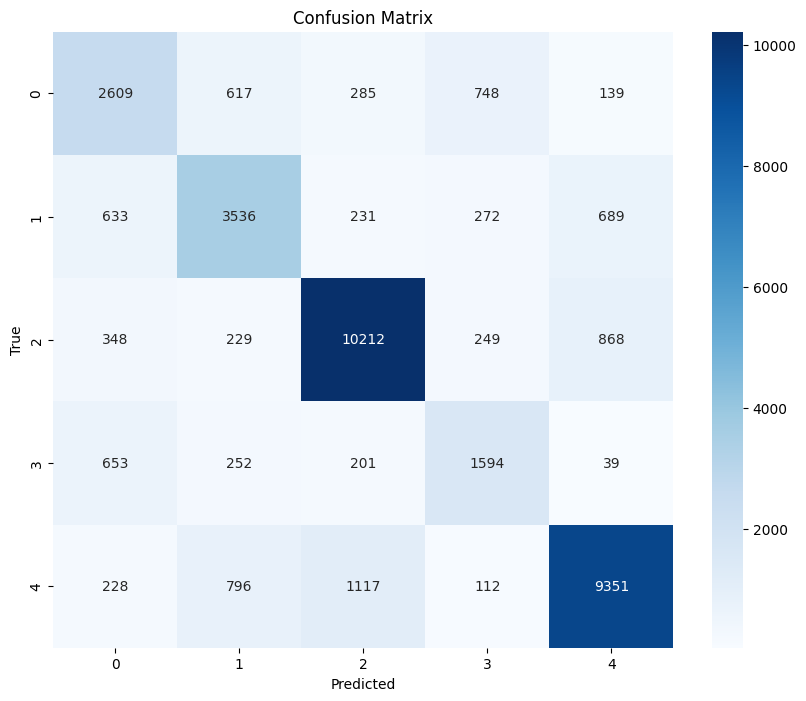


Example Classification:
Text: We conducted a randomized controlled trial to evaluate the efficacy 
                 of the new treatment method in patients with stage 2 breast cancer.
Predicted class: BACKGROUND


['medical_text_classifier.joblib']

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Download and prepare the dataset
import requests
import os

def download_dataset(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                f.write(response.content)
            print("Download completed!")
        else:
            raise Exception(f"Failed to download file: {response.status_code}")
    else:
        print(f"File {filename} already exists, skipping download.")

# Download the dataset
url = "https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
download_dataset(url, "train.txt")

def load_data(file_path):
    texts = []
    labels = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                # Split on first tab only
                parts = line.split('\t', 1)
                if len(parts) != 2:
                    print(f"Skipping malformed line {line_number}: {line}")
                    continue

                label, text = parts
                # Additional validation
                if label and text:  # Ensure both label and text are non-empty
                    texts.append(text)
                    labels.append(label)
                else:
                    print(f"Skipping line {line_number}: Empty label or text")
            except Exception as e:
                print(f"Error processing line {line_number}: {str(e)}")
                continue

    if not texts or not labels:
        raise ValueError("No valid data found in the file")

    print(f"Successfully loaded {len(texts)} samples")
    return texts, labels

# Load the data
texts, labels = load_data('train.txt')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Create a pipeline with TF-IDF vectorizer and SVM classifier
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words='english'
    )),
    ('clf', LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

# Train the model
text_clf.fit(X_train, y_train)

# Make predictions
y_pred = text_clf.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Function to classify new text
def classify_text(text):
    prediction = text_clf.predict([text])[0]
    return prediction

# Example usage
example_text = """We conducted a randomized controlled trial to evaluate the efficacy
                 of the new treatment method in patients with stage 2 breast cancer."""
print("\nExample Classification:")
print(f"Text: {example_text}")
print(f"Predicted class: {classify_text(example_text)}")

# Save the model (optional)
import joblib
joblib.dump(text_clf, 'medical_text_classifier.joblib')

# To load the model later:
# loaded_model = joblib.load('medical_text_classifier.joblib')